In [1]:
# Imports from the helpers folder, containing the lstm code and auxilliary functions
import sys  
sys.path.insert(0, "../helpers")
from lstm import Model, Optimization
from aux_functions import (ts_train_test_split, ts_train_test_keepnr)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pltio
import statsmodels.api as sm
from datetime import datetime, timedelta
# Packages for forecasting
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [2]:
## Milan data
milan_data_df = pd.read_csv("../../datasets/ts_data/daily_aug/aug_milan_cc_arese_data.csv", index_col=[0], parse_dates=True)
turin_data_df = pd.read_csv("../../datasets/ts_data/daily_aug/aug_turin_cc_torin_data.csv", index_col=[0], parse_dates=True)
rome_data_df = pd.read_csv("../../datasets/ts_data/daily_aug/aug_rome_cc_eur2_data.csv", index_col=[0], parse_dates=True)

print("Shape (dim) of datasets:")
print("Milan:", milan_data_df.shape)
print("Turin:", turin_data_df.shape)
print("Rome:", rome_data_df.shape)

# Create dicts for different store data, useful when running the forecasting experiments
datasets = {
    "Milan": milan_data_df,
    "Turin": turin_data_df,
    "Rome": rome_data_df
}

Shape (dim) of datasets:
Milan: (1357, 16)
Turin: (1460, 16)
Rome: (475, 16)


# Data Visualization and Exploration 

Milan data 



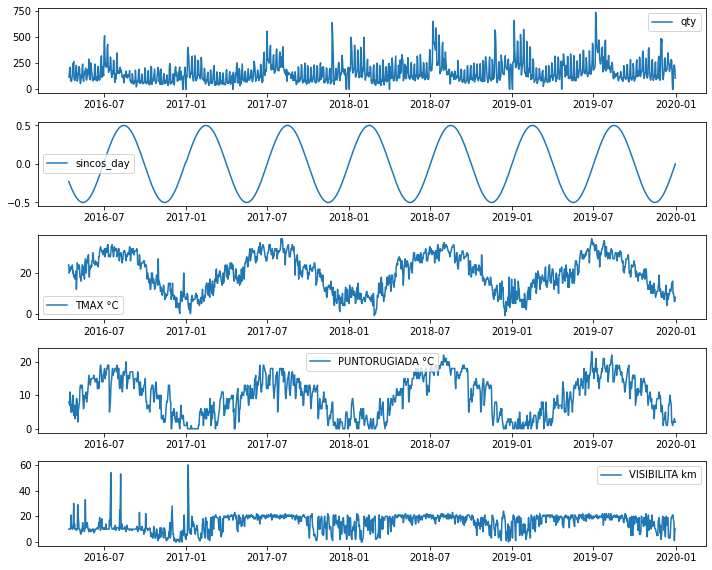

Turin data 



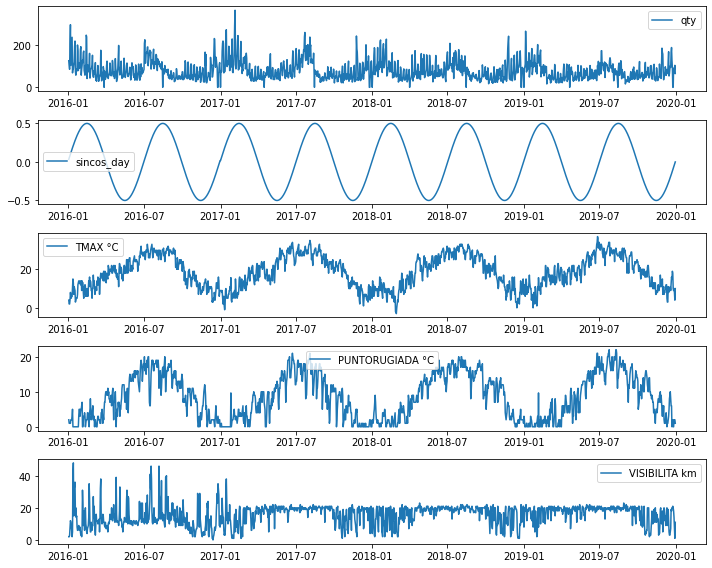

Rome data 



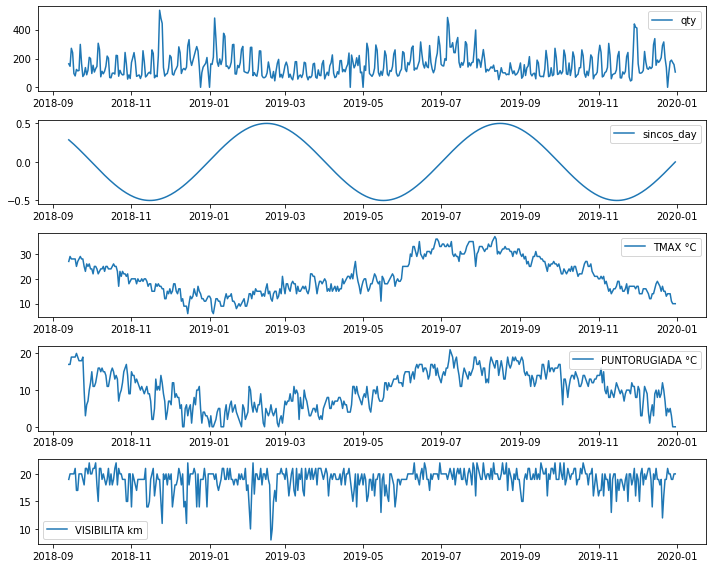

In [3]:
# Plot the data to explore and see what we are working with
# Here we can see what the features we will train the network on later look like
for dataset in datasets:
    print(dataset, "data \n")
    values = datasets[dataset].values
    cols_to_plot = [0,3,7,8,10]
    i=1
    plt.figure(figsize=(10,8))
    for col in cols_to_plot:
        plt.subplot(len(cols_to_plot), 1, i)
        plt.plot(datasets[dataset].iloc[:, col], label=datasets[dataset].columns[col])
        plt.legend()
        i += 1
    #plt.savefig("mono_exog_features_plot.png", transparent = True, bbox_inches = 'tight', pad_inches = 0)
    plt.tight_layout() 
    plt.show()

# LSTM helper functions

In [4]:
def build_in_out_seq(tr_df, te_df, desired_input_features, in_len, out_len):
    # Building the NN input and outputs. LSTM will expect a supervised learning problem, hence we need to build
    # input sequences that will have output sequences which the model will then learn.
    
    # Training
    inp_tr = np.stack([tr_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len:, -1::-1, desired_input_features].copy()
    out_tr = np.stack([tr_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len:, -1::-1, desired_input_features].copy()
    # Testing
    inp_te = np.stack([te_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len:, -1::-1, desired_input_features].copy()
    out_te = np.stack([te_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len:, -1::-1, desired_input_features].copy()
    print("Inputs for training")
    print(inp_tr.shape)
    print("Outputs for training")
    print(out_tr.shape)
    print("Inputs for testing")
    print(inp_te.shape)
    print("Outputs for testing")
    print(out_te.shape)
    print("\n")
    return inp_tr, out_tr, inp_te, out_te

def prepare_for_network(train, test, input_features, in_len, out_len):
    # Build the full training and testing dataframes
    # In order to pass the data to the LSTM we need to transform it so it is in the range [0,1]
    # We scale all our data in order to build the final training and test dataframes
    
    tr_df = train.copy(deep=True)
    te_df = test.copy(deep=True)
    
    for col in tr_df.columns:
        # Z standartization
        mean = np.mean(train.loc[:,col].values)
        std = np.std(train.loc[:,col].values)
        if (((tr_df.loc[:, col].values >= -1) & (tr_df.loc[:, col].values <= 1)).all()):
            pass
        else:
            tr_df.loc[:, col] = (train.loc[:,col].values-mean)/std
            te_df.loc[:, col] = (test.loc[:,col].values-mean)/std

    # Prepare data for the LSTM Network: We need to create sequences of inputs and outputs
    # so that our time series problem esentially becomes a "supervised regression problem".
    inp_tr, out_tr, inp_te, out_te = build_in_out_seq(tr_df, te_df, input_features, in_len, out_len)
    return inp_tr, out_tr, inp_te, out_te

def define_LSTM_Model(input_features):
    loss_fn = nn.MSELoss()
    LSTM_Model = Model(input_size=len(input_features), hidden_size=128, output_size=len(input_features))
    optimizer = optim.Adam(LSTM_Model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=25, gamma=0.1)
    opt_obj = Optimization(LSTM_Model, loss_fn, optimizer, scheduler)
    return LSTM_Model, opt_obj

def check_lstm_forecast_results(pred, inp_te, out_te, mean, std, in_len, out_len):
    # Rescales the data back to nrm vals first
    pred_vec = (pred[:,-out_len:,0].detach().cpu().numpy() * std) + mean
    real_vec = (out_te[:,:,0] * std) + mean
    rmse = sm.tools.eval_measures.rmse(pred_vec, real_vec)
    mae = sm.tools.eval_measures.meanabs(pred_vec, real_vec)
    return rmse, mae

def build_lstm_full_preds(out_sq, pred_seq, out_len, mean, std):
    lstm_step_preds = []
    for i in range(0, out_sq.shape[0], out_len):
        lstm_step_preds.extend(((pred_seq[i,-out_len:,0].detach().cpu().numpy()*std)+mean))
          
    return lstm_step_preds

def check_local_res(testset, preds, inp_te, out_te, mean, std, in_len, out_len):
    
    seq_nr = out_te.shape[0]
    selected_seq = [0, int(seq_nr/2), seq_nr-1]
    idx_for_seq = [testset.index[val:val+in_len+out_len] for val in selected_seq]
    idx_for_seq
    for i, seq in enumerate(selected_seq):
        input_vec = (inp_te[seq,:,0]*std)+mean
        real_vec = (out_te[seq,:,0]*std)+mean
        full_gt_vec = input_vec.tolist()
        full_gt_vec.extend(real_vec.tolist())

        plt.figure(figsize=(16,8))
        plt.plot(idx_for_seq[i], full_gt_vec, label="Train")
        plt.plot(idx_for_seq[i][in_len:], real_vec, label="Expected Output")

        for j, pred in enumerate(preds):
            curr_pred = preds[j]
            pred_vec = (curr_pred[seq,-out_len:,0].detach().cpu().numpy()*std)+mean
            plt.plot(idx_for_seq[i][in_len:], pred_vec, label="Forecast " + str(j))
            rmse = sm.tools.eval_measures.rmse(real_vec, pred_vec)
            mae = sm.tools.eval_measures.meanabs(real_vec, pred_vec)
            print("Forecast " + str(j) + " RMSE and MAE", rmse, mae)
        plt.legend()
        plt.show()

# Forecasting evaluation

In [25]:
single_run_results = []
me_results = []
n_runs = 1
for dataset in datasets:
    print("Running forecasting for sales in", dataset, "\n")
    for run in range(n_runs):
        print ("Run #", run+1)

        # Add day of week as one hot encoded signal before running the lstm model
        full_dataset = datasets[dataset]

        # Create training and test data
        train, test = ts_train_test_split(full_dataset, 0.1)
        print(train.shape, test.shape)

        # Extract the columns which display most correlation with the value we are trying to predict.
        mono_input_features = [0]
        exo1_input_features = [0, 1, 2, 3, 4]
        exo2_input_features = [0] + list(range(5,full_dataset.shape[1]))
        exo3_input_features = [0, 1, 2, 3, 4, 5, full_dataset.shape[1]-1] 
        print("MONO-LSTM input features:", mono_input_features)
        print("EXO1 (+ sincos day) input features :", exo1_input_features)
        print("EXO2 (+ weather exog) input features :", exo2_input_features)
        print("EXO3 (+ all exog) input features :", exo3_input_features)
        print()

        ## LSTM
        # Define lstm input and output size
        lstm_in_len = 7
        lstm_out_len = 1
        
        # Define the LSTM Models and their Optimizer objects
        mono_LSTM_Model, mono_opt_obj = define_LSTM_Model(mono_input_features)
        exo1_LSTM_Model, exo1_opt_obj = define_LSTM_Model(exo1_input_features)
        exo2_LSTM_Model, exo2_opt_obj = define_LSTM_Model(exo2_input_features)
        exo3_LSTM_Model, exo3_opt_obj = define_LSTM_Model(exo3_input_features)

        # 1) MONO-LSTM data
        mono_inp_tr, mono_out_tr, mono_inp_te, mono_out_te = prepare_for_network(train, test, mono_input_features, in_len=lstm_in_len, out_len=lstm_out_len)
        mono_x_train=torch.cat((torch.Tensor(mono_inp_tr),torch.Tensor(mono_out_tr)),1)
        mono_x_test=torch.Tensor(mono_inp_te)
        
        # 2) EXO1-LSTM data
        exo1_inp_tr, exo1_out_tr, exo1_inp_te, exo1_out_te = prepare_for_network(train, test, exo1_input_features, in_len=lstm_in_len, out_len=lstm_out_len)
        exo1_x_train=torch.cat((torch.Tensor(exo1_inp_tr),torch.Tensor(exo1_out_tr)),1)
        exo1_x_test=torch.Tensor(exo1_inp_te)

        # 3) EXO2-LSTM data
        exo2_inp_tr, exo2_out_tr, exo2_inp_te, exo2_out_te = prepare_for_network(train, test, exo2_input_features, in_len=lstm_in_len, out_len=lstm_out_len)
        exo2_x_train=torch.cat((torch.Tensor(exo2_inp_tr),torch.Tensor(exo2_out_tr)),1)
        exo2_x_test=torch.Tensor(exo2_inp_te)

        # 2) EXO3-LSTM data
        exo3_inp_tr, exo3_out_tr, exo3_inp_te, exo3_out_te = prepare_for_network(train, test, exo3_input_features, in_len=lstm_in_len, out_len=lstm_out_len)
        exo3_x_train=torch.cat((torch.Tensor(exo3_inp_tr),torch.Tensor(exo3_out_tr)),1)
        exo3_x_test=torch.Tensor(exo3_inp_te)
        
        # Train all the LSTMs 
        print("Training the MONO-LSTM model...")
        mono_opt_obj.train(mono_x_train[:,:-1],mono_x_train[:,1:],mono_x_train[:,:-1],mono_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=21, batch_size=64)
        print("Done\n")
        print("Training the EXO1-LSTM model...")
        exo1_opt_obj.train(exo1_x_train[:,:-1],exo1_x_train[:,1:],exo1_x_train[:,:-1],exo1_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=21, batch_size=64)
        print("Done\n")
        print("Training the EXO2-LSTM model...")
        exo2_opt_obj.train(exo2_x_train[:,:-1],exo2_x_train[:,1:],exo2_x_train[:,:-1],exo2_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=21, batch_size=64)
        print("Done\n")
        print("Training the EXO3-LSTM model...")
        exo3_opt_obj.train(exo3_x_train[:,:-1],exo3_x_train[:,1:],exo3_x_train[:,:-1],exo3_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=21, batch_size=64)
        print("Done\n")        

        # Make predictions using the trained networks
        mono_pred = mono_LSTM_Model(mono_x_test, lstm_out_len)
        exo1_pred = exo1_LSTM_Model(exo1_x_test, lstm_out_len)
        exo2_pred = exo2_LSTM_Model.predict_mono(exo2_x_test, lstm_out_len, exo2_x_test)
        exo3_pred = exo3_LSTM_Model.predict_mono(exo3_x_test, lstm_out_len, exo3_x_test)

        ## Check results of LSTM forecasts (calc erros)
        mean = np.mean(train.qty.values)
        std = np.std(train.qty.values)
        full_mono_pred = build_lstm_full_preds(mono_out_te, mono_pred, lstm_out_len, mean, std)
        mono_lstm_rmse = sm.tools.eval_measures.rmse(test.qty[lstm_in_len+1:].values, full_mono_pred)
        mono_lstm_mae = sm.tools.eval_measures.meanabs(test.qty[lstm_in_len+1:].values, full_mono_pred)
        
        full_exo1_pred = build_lstm_full_preds(exo1_out_te, exo1_pred, lstm_out_len, mean, std)
        exo1_lstm_rmse = sm.tools.eval_measures.rmse(test.qty[lstm_in_len+1:].values, full_exo1_pred)
        exo1_lstm_mae = sm.tools.eval_measures.meanabs(test.qty[lstm_in_len+1:].values, full_exo1_pred)
        
        full_exo2_pred = build_lstm_full_preds(exo2_out_te, exo2_pred, lstm_out_len, mean, std)
        exo2_lstm_rmse = sm.tools.eval_measures.rmse(test.qty[lstm_in_len+1:].values, full_exo2_pred)
        exo2_lstm_mae = sm.tools.eval_measures.meanabs(test.qty[lstm_in_len+1:].values, full_exo2_pred)
        
        full_exo3_pred = build_lstm_full_preds(exo3_out_te, exo3_pred, lstm_out_len, mean, std)
        exo3_lstm_rmse = sm.tools.eval_measures.rmse(test.qty[lstm_in_len+1:].values, full_exo3_pred)
        exo3_lstm_mae = sm.tools.eval_measures.meanabs(test.qty[lstm_in_len+1:].values, full_exo3_pred)
        
        
        ## New metric to show if typically the error is negative or positive
        mono_lstm_me = np.mean((test.qty[lstm_in_len+1:].values - full_mono_pred))
        exo1_lstm_me = np.mean((test.qty[lstm_in_len+1:].values - full_exo1_pred)/len(test.qty[lstm_in_len+1:].values))
        exo2_lstm_me = np.mean((test.qty[lstm_in_len+1:].values - full_exo2_pred)/len(test.qty[lstm_in_len+1:].values))
        exo3_lstm_me = np.mean((test.qty[lstm_in_len+1:].values - full_exo3_pred)/len(test.qty[lstm_in_len+1:].values))

        fig = go.Figure()
        full_labels = test.index
        pred_labels = test.index[lstm_in_len+1:]
        fig.add_trace(go.Scatter(x=full_labels, y=test.qty,
                    mode='lines', name='Ground Truth'))
        fig.add_trace(go.Scatter(x=pred_labels, y=full_mono_pred,
                     mode='lines', name="MONO-LSTM. RMSE %.2f" % mono_lstm_rmse ))
        fig.add_trace(go.Scatter(x=pred_labels, y=full_exo1_pred,
                     mode='lines', name="EXO1-LSTM. RMSE %.2f" % exo1_lstm_rmse))
        fig.add_trace(go.Scatter(x=pred_labels, y=full_exo2_pred,
                     mode='lines', name="EXO2-LSTM. RMSE %.2f" % exo2_lstm_rmse))
        fig.add_trace(go.Scatter(x=pred_labels, y=full_exo3_pred,
                     mode='lines', name="EXO3-LSTM. RMSE %.2f" % exo3_lstm_rmse))
        
        ## add dates for the axis
        fig.update_layout(
            title="Daily rolling forecast of last " + str(mono_inp_te.shape[0]) + " in " + dataset,
            xaxis_title="Days",
            yaxis_title="Sold amount",
        )
        fig.show()
        pltio.write_html(fig, dataset+"-daily-sales-results.html" + str(1))

        single_run_results.append([dataset, mono_lstm_rmse, exo1_lstm_rmse, exo2_lstm_rmse, \
                                   exo3_lstm_rmse, mono_lstm_mae, exo1_lstm_mae, exo2_lstm_mae, exo3_lstm_mae
                                  ])
    
        me_results.append([dataset, mono_lstm_me, exo1_lstm_me, exo2_lstm_me, exo3_lstm_me])

        print()

Running forecasting for sales in Milan 

Run # 1
(1222, 16) (135, 16)
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3, 4]
EXO2 (+ weather exog) input features : [0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 15]

Inputs for training
(1214, 7, 1)
Outputs for training
(1214, 1, 1)
Inputs for testing
(127, 7, 1)
Outputs for testing
(127, 1, 1)


Inputs for training
(1214, 7, 5)
Outputs for training
(1214, 1, 5)
Inputs for testing
(127, 7, 5)
Outputs for testing
(127, 1, 5)


Inputs for training
(1214, 7, 12)
Outputs for training
(1214, 1, 12)
Inputs for testing
(127, 7, 12)
Outputs for testing
(127, 1, 12)


Inputs for training
(1214, 7, 7)
Outputs for training
(1214, 1, 7)
Inputs for testing
(127, 7, 7)
Outputs for testing
(127, 1, 7)


Training the MONO-LSTM model...
Epoch 1 Train loss: 0.96. Validation loss: 0.90. Avg future: 1.94. Elapsed time: 0.34s.
Epoch 2 Train loss: 0.88. Validation loss: 0.85. Avg f

Epoch 20 Train loss: 0.22. Validation loss: 0.22. Avg future: 2.06. Elapsed time: 0.31s.
Epoch 21 Train loss: 0.21. Validation loss: 0.22. Avg future: 2.00. Elapsed time: 0.38s.
Done




Running forecasting for sales in Turin 

Run # 1
(1314, 16) (146, 16)
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3, 4]
EXO2 (+ weather exog) input features : [0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 15]

Inputs for training
(1306, 7, 1)
Outputs for training
(1306, 1, 1)
Inputs for testing
(138, 7, 1)
Outputs for testing
(138, 1, 1)


Inputs for training
(1306, 7, 5)
Outputs for training
(1306, 1, 5)
Inputs for testing
(138, 7, 5)
Outputs for testing
(138, 1, 5)


Inputs for training
(1306, 7, 12)
Outputs for training
(1306, 1, 12)
Inputs for testing
(138, 7, 12)
Outputs for testing
(138, 1, 12)


Inputs for training
(1306, 7, 7)
Outputs for training
(1306, 1, 7)
Inputs for testing
(138, 7, 7)
Outputs for testing
(138, 1, 7)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.05. Validation loss: 0.98. Avg future: 2.20. Elapsed time: 0.43s.
Epoch 2 Train loss: 0.92. Validation loss: 0.87. Avg 

Epoch 20 Train loss: 0.21. Validation loss: 0.22. Avg future: 2.00. Elapsed time: 0.42s.
Epoch 21 Train loss: 0.21. Validation loss: 0.21. Avg future: 1.95. Elapsed time: 0.31s.
Done




Running forecasting for sales in Rome 

Run # 1
(428, 16) (47, 16)
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3, 4]
EXO2 (+ weather exog) input features : [0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 15]

Inputs for training
(420, 7, 1)
Outputs for training
(420, 1, 1)
Inputs for testing
(39, 7, 1)
Outputs for testing
(39, 1, 1)


Inputs for training
(420, 7, 5)
Outputs for training
(420, 1, 5)
Inputs for testing
(39, 7, 5)
Outputs for testing
(39, 1, 5)


Inputs for training
(420, 7, 12)
Outputs for training
(420, 1, 12)
Inputs for testing
(39, 7, 12)
Outputs for testing
(39, 1, 12)


Inputs for training
(420, 7, 7)
Outputs for training
(420, 1, 7)
Inputs for testing
(39, 7, 7)
Outputs for testing
(39, 1, 7)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.23. Validation loss: 1.22. Avg future: 2.00. Elapsed time: 0.10s.
Epoch 2 Train loss: 1.21. Validation loss: 1.20. Avg future: 2.00. Elaps

Epoch 20 Train loss: 0.39. Validation loss: 0.39. Avg future: 2.00. Elapsed time: 0.12s.
Epoch 21 Train loss: 0.37. Validation loss: 0.38. Avg future: 2.50. Elapsed time: 0.11s.
Done



In [26]:
# Results for each run of forecasting
single_run_results_df = pd.DataFrame(single_run_results, 
                                     columns= ["Dataset", "MONO-LSTM RMSE", "EXO1-LSTM RMSE", "EXO2-LSTM RMSE", \
                                               "EXO3-LSTM RMSE","MONO-LSTM MAE", "EXO1-LSTM MAE", "EXO2-LSTM MAE",\
                                               "EXO3-LSTM MAE"])
single_run_results_df

,Dataset,MONO-LSTM RMSE,EXO1-LSTM RMSE,EXO2-LSTM RMSE,EXO3-LSTM RMSE,MONO-LSTM MAE,EXO1-LSTM MAE,EXO2-LSTM MAE,EXO3-LSTM MAE
0,Milan,64.796398,72.115516,86.569840,61.675890,49.494548,52.890286,63.348881,45.081576
1,Turin,29.567489,29.493743,33.166687,27.712997,22.591838,20.588863,25.186357,20.432510
2,Rome,85.711601,88.745773,100.574586,81.597128,60.646077,74.613923,72.279936,65.482032


In [29]:
# Mean for all cities
single_run_results_df.mean()

MONO-LSTM RMSE    60.025163
EXO1-LSTM RMSE    63.451677
EXO2-LSTM RMSE    73.437037
EXO3-LSTM RMSE    56.995338
MONO-LSTM MAE     44.244154
EXO1-LSTM MAE     49.364357
EXO2-LSTM MAE     53.605058
EXO3-LSTM MAE     43.665373
dtype: float64

In [27]:
# Mean error
me_results_df = pd.DataFrame(me_results, columns=["Dataset", "MONO-LSTM ME", "EXO1-LSTM ME", "EXO2-LSTM ME", "EXO3-LSTM ME"])
me_results_df

,Dataset,MONO-LSTM ME,EXO1-LSTM ME,EXO2-LSTM ME,EXO3-LSTM ME
0,Milan,-22.938284,0.128967,0.191806,0.134125
1,Turin,0.486645,0.017290,0.044518,0.011813
2,Rome,18.049331,-0.242268,0.779061,0.181102


In [30]:
np.sum(test.qty)

8209

In [13]:
np.sum(full_mono_pred)

7796.6523

In [1]:
for nr, br in [0,2],[1,3]:
    print(nr, br)

0 2
1 3
